<a href="https://colab.research.google.com/github/BautistaBertolami/Cap4630AI/blob/master/HW4/HW4Problem3V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Example data (original code by Pawel Wocjan, adapted to xception by Bautista Bertolami

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 01:49:13--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.14.112, 2607:f8b0:4007:80d::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.14.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   199MB/s    in 0.3s    

2020-04-21 01:49:13 (199 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Building a network with Xception as the base

In [4]:
from keras.applications import Xception

conv_base = Xception(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(150, 150, 3))

Using TensorFlow backend.


83689472/83683744 [==============================] - 2s 0us/step


Freeze conv base

In [0]:
conv_base.trainable = False

Concatenate the base and dense layers, in this version of problem 3 the model has an extra dense layer

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu')) #added extra layer difference from V1
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 34,034,985
Trainable params: 13,173,505
Non-trainable params: 20,861,480
_________________________________________________________________


Train the model with frozen conv base, and also smaller learning rate than V1

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-7), #smaller learning rate than V1
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 30s 298ms/step - loss: 0.6970 - acc: 0.5095 - val_loss: 0.5690 - val_acc: 0.7070
Epoch 2/30
100/100 [==============================] - 20s 201ms/step - loss: 0.6796 - acc: 0.5585 - val_loss: 0.5946 - val_acc: 0.7840
Epoch 3/30
100/100 [==============================] - 20s 201ms/step - loss: 0.6625 - acc: 0.6005 - val_loss: 0.4623 - val_acc: 0.8360
Epoch 4/30
100/100 [==============================] - 20s 200ms/step - loss: 0.6471 - acc: 0.6235 - val_loss: 0.4518 - val_acc: 0.8550
Epoch 5/30
100/100 [==============================] - 20s 201ms/step - loss: 0.6350 - acc: 0.6590 - val_loss: 0.3966 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 20s 199ms/step - loss: 0.6240 - acc: 0.6645 - val_loss: 0.3319 - val_acc: 0.8930
Epoch 7/30
100/100 [==============================] - 20s 199ms/step - loss: 0.6061 - acc: 0.7010 - val_lo

Display accuracy and loss

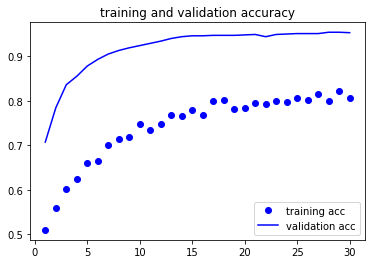

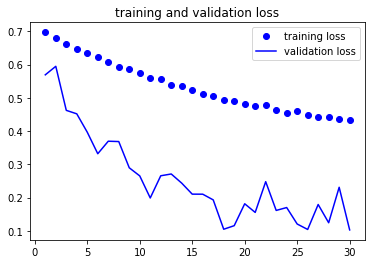

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block3_pool':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

Another difference in the model is the learning rate

In [11]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-7), #smaller learning rate than V1 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 37s 366ms/step - loss: 0.4253 - acc: 0.8180 - val_loss: 0.1770 - val_acc: 0.9230
Epoch 2/100
100/100 [==============================] - 28s 282ms/step - loss: 0.4237 - acc: 0.8200 - val_loss: 0.3272 - val_acc: 0.9130
Epoch 3/100
100/100 [==============================] - 28s 281ms/step - loss: 0.4258 - acc: 0.8125 - val_loss: 0.3169 - val_acc: 0.9030
Epoch 4/100
100/100 [==============================] - 28s 281ms/step - loss: 0.4157 - acc: 0.8195 - val_loss: 0.2592 - val_acc: 0.8980
Epoch 5/100
100/100 [==============================] - 28s 281ms/step - loss: 0.4256 - acc: 0.8200 - val_loss: 0.1663 - val_acc: 0.8980
Epoch 6/100
100/100 [==============================] - 28s 281ms/step - loss: 0.4168 - acc: 0.8155 - val_loss: 0.3412 - val_acc: 0.9010
Epoch 7/100
100/100 [==============================] - 28s 281ms/step - loss: 0.4134 - acc: 0.8150 - val_loss: 0.2633 - val_acc: 0.9030
Epoch 8/100
100/100 [===========================

Fine tuning curves

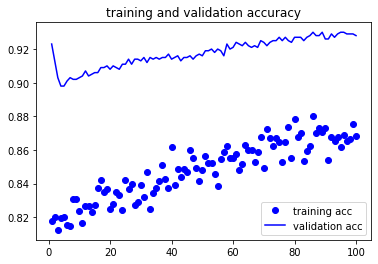

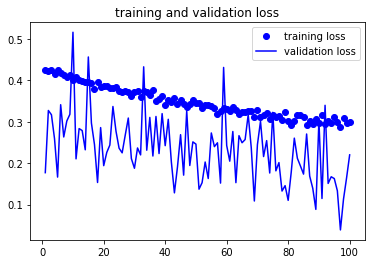

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [14]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.2880212664604187
Validation accuracy: 0.9279999732971191
